In [141]:
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import arff
import pandas as pd
import scipy.stats as stats
import seaborn as sns
sns.set(style="dark")
import pywt
from scipy.special import erfcinv
from scipy.signal import butter, convolve

from tqdm import tqdm

# Algorithms

In [142]:
def iterativeWaveletDenoising( signal, waveletname, level, alpha_1, mode = "soft"):
    coeffs = pywt.wavedec(signal, waveletname, level = level) 


    details = coeffs[1:]

    new_details = []

    alpha = alpha_1

    for detail in details:
        new_detail = detail.copy()
        s = np.std(detail, ddof=0)
        d = np.sqrt(2) * erfcinv(alpha)
        while (np.abs(detail) > s*d).any():
            indices_to_delete = np.argwhere(np.abs(detail) > s*d)
            detail = np.delete(detail, indices_to_delete)
            s = np.std(detail)



            
        threshold = s*d

        new_detail = pywt.threshold(new_detail, threshold, mode=mode)
        new_details.append(new_detail)
        alpha += alpha_1

    new_coeffs = [coeffs[0]] + new_details
    denoised_signal = pywt.waverec(new_coeffs, waveletname)

    return denoised_signal


def baselineWaveletDenoising(signal, waveletname, level, threshold_percent= 0.9, mode = "soft"):
    coeffs = pywt.wavedec(signal, waveletname, level = level) 
    details = coeffs[1:]
    new_details = []
    for detail in details:
        #Méthode de base : on prend le seuil à 0.9*max (tous ceux en dessous sont tronqués)
        threshold = threshold_percent*np.max(detail)
        new_detail = pywt.threshold(detail, threshold, mode="soft")
        new_details.append(new_detail)

    new_coeffs = [coeffs[0]] + new_details
    denoised_signal = pywt.waverec(new_coeffs, waveletname)

    return denoised_signal

In [143]:
def metrics(signal, denoised_signal):

    #MSE
    rmse = np.mean((signal - denoised_signal)**2)**0.5

    #SNR
    snr = 10*np.log10(np.var(signal)/np.var(signal - denoised_signal))

    prd = np.sqrt( (np.sum(np.square(signal - denoised_signal))) / (np.sum(np.square(signal))))

    d_max = np.max (np.abs(signal - denoised_signal))

    return rmse, snr, prd, d_max

In [144]:
def mdct_atoms(signal, L, k):
    """
    Returns the MDCT atom for a scale L  and frequency k, 0-padded to match the length of the signal.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    L : int
        The scale of the MDCT atom.
    k : int
        The frequency of the MDCT atom.

    Returns
    -------
    array_like, shape (N,)
        The MDCT atom for a scale L (length 2L)  and frequency k, 0-padded to match the length of the signal.
    """
    N = len(signal)
    u = np.arange(0, 2*L - 1, 1)
    res = np.sin(np.pi * (u +0.5) / (2*L)) * np.sqrt(2/L) * np.cos( (np.pi /L) * (u + 0.5*(L+1)) * (k + 0.5) )
    if N > 2*L - 1:
        return np.hstack((res, np.zeros(N - (2*L - 1))))
    return

def buildDictionary(signal, Ls):
    """
    Returns the whole dictionary of MDCT atoms for a given signal and list of scale Ls.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    Ls : list
        The list of scales for the MDCT atoms.

    Returns
    -------
    array_like, shape (N, len(Ls))
        The whole dictionary of MDCT atoms for a given signal and list of scale Ls.
    """

    N = len(signal)
    dictionary = np.zeros((N, 1))
    for L in Ls:
        for k in range(L):
            dictionary = np.hstack((dictionary, mdct_atoms(signal, L, k).reshape((N, 1))))
    return dictionary[:, 1:]

def orthogonalMatchingPursuit(signal, D, K):
    """
    Returns the indices of the K atoms of the dictionary D that best match the signal.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    D : array_like, shape (N, M)
        The dictionary of MDCT atoms.
    K : int
        The number of atoms to select.

    Returns
    -------
    support: array_like, shape (N, K)
        The indices of the K atoms of the dictionary D that best match the signal. Each atom is a column of D suitably shifted, see "Placement" in the code.
    norm_residuals: array_like, shape (K+1,)
        The norm of the residual at each iteration.
    reconstruction: array_like, shape (N,)
        The reconstruction of the signal (projection over the selected atoms)
    """
    N = len(signal)
    residual = signal
    norm_residuals = [np.linalg.norm(residual)]
    support = np.empty((N, K))
    flipDic = np.flipud(D)
    for _ in range(K):
        #We compute the full convolution of each atom with the signal
        convolutions = np.abs(convolve(residual.reshape(-1,1), flipDic, mode='full')) #shape (4095, 2016)
        correlations = np.max(convolutions,axis=0) #shape (2016,). We take the max of each column (correlation of each atom = max of the convolution)
        index_atom = np.argmax(correlations) #Best correlation

        #"Placement" of the atom in a (2048, ) vector
        start=np.argmax(convolutions[: , index_atom])
        begin=max(start-(N-1),0)
        end =min(start,N-1)

        atom=np.hstack((np.zeros(begin),D[begin+(N-1)-start:end+(N-1)-start,index_atom],np.zeros(N-end)))

        #Update support
        support[:, _] = atom.reshape((N, ))
        support[:, :_] /= np.linalg.norm(support[:, :_], axis = 0) #Normalization, because we will project using pseudo-inverse

        #Update residual
        S = support[:, :_+1]

        try :
            STS_inv = np.linalg.inv(S.T@S)
        except np.linalg.LinAlgError:
            eps = 10**(-6)
            STS_inv = np.linalg.inv(S.T@S + eps*np.eye(S.shape[1]))
        reconstruction = S@STS_inv@S.T@signal
        residual = signal - reconstruction
        norm_residuals.append(np.linalg.norm(residual))

    return support, norm_residuals, reconstruction




# Data loading and noising

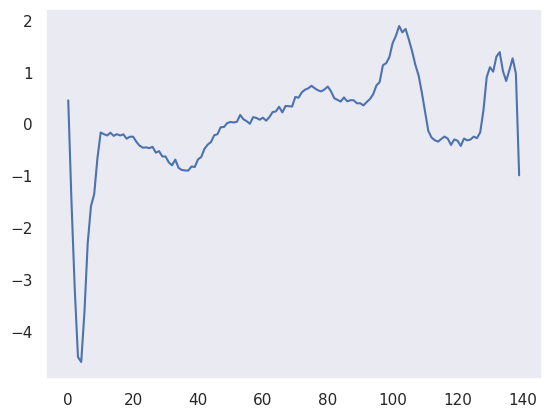

In [145]:
#Importation of signal 
# Load ARFF file
data, meta = arff.loadarff('ECG5000_TRAIN.arff')

# Convert to DataFrame
df = pd.DataFrame(data)
df = df[df['target'] == b'1'].copy() #keep only the first class
df.drop('target', axis=1, inplace=True) #drop the class number

i = 7
line = df.iloc[i]

line = line.astype(float).tolist()

#Normalize signal
line = line

plt.plot([i for i in range(len(line))],line)
plt.show()

Original RMSE :  0.33354023380851716
Original SNR :  9.5107027888372


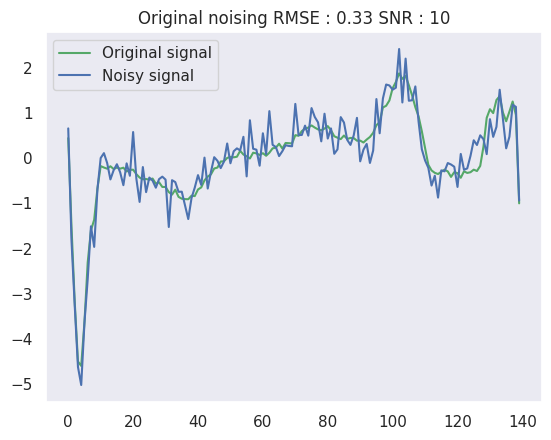

Input SNR :  9.5107027888372


In [146]:
def addNoise(line, SNR):
    log_ratio = SNR / 10
    noise_variance = np.var(line) / (10 ** log_ratio)
    noise = np.sqrt(noise_variance) * np.random.randn(len(line))
    return line + noise, noise_variance, noise

def addNoise2(line, noise_var):
    noise = np.sqrt(noise_var) * np.random.randn(len(line))
    SNR = 10 * np.log10(np.var(line) / np.var(noise))
    return line + noise, SNR, noise

noisy_line, noise_var , noise = addNoise(line, 10)
rmse, snr, prd, d_max = metrics(line, noisy_line)
print("Original RMSE : ", rmse)
print("Original SNR : ", snr)


plt.plot(line, 'g', label = "Original signal")
plt.plot(noisy_line, label = "Noisy signal")
plt.title("Original noising RMSE : " + str(round(rmse, 2)) + " SNR : " + str(10))
plt.legend()
plt.show()



print("Input SNR : ", snr)

# Algorithms training

In [147]:
levels = [2,3,4]
res = np.zeros((len(pywt.wavelist()), len(levels)))
best_prd = 1

for i, waveletname in tqdm(enumerate(pywt.wavelist(kind = 'discrete'))):
    for j, level in enumerate(levels):
        denoised_line = iterativeWaveletDenoising(noisy_line, waveletname, level, 0.01)
        mse, snr, prd, d_max = metrics(line, denoised_line)
        res[i, j] = prd
        if prd < best_prd:
            best_prd = prd
            best_wavelet = waveletname
            best_level = level
        
print("--------------")
print(best_prd)
print(best_wavelet)
print(best_level)
    

1it [00:00,  5.53it/s]/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
16it [00:00, 67.86it/s]/home/max/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
106it [00:01, 102.86it/s]

--------------
0.2098531511615697
sym15
2


Output SNR :  13.421646065876523


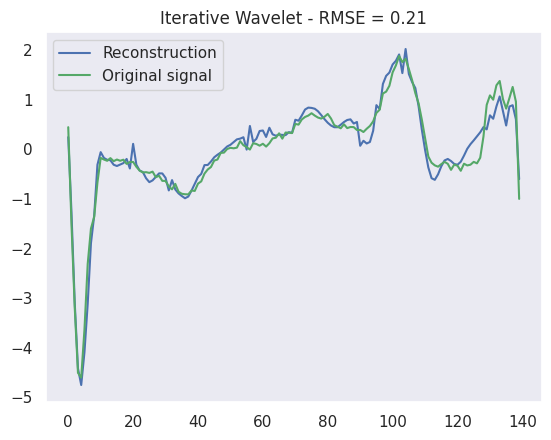

In [148]:
denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, 0.015)
mse, snr, prd, d_max = metrics(line, denoised_line)
print("Output SNR : ", snr)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Iterative Wavelet - RMSE = " + str(round(mse,2)))
plt.legend()
plt.show()

100%|██████████| 20/20 [00:00<00:00, 898.20it/s]

Best threshold :  0.24210526315789474
Output SNR :  12.06025376640904


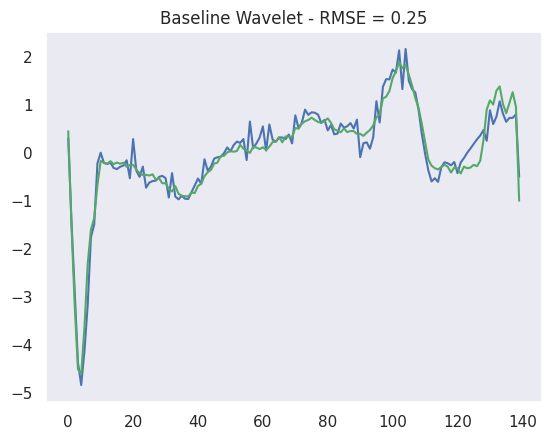

In [149]:
threshold_percents = np.linspace(0.1, 1, 20)

best_prd = 1

for thresh in tqdm(threshold_percents):
    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, thresh)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    if prd < best_prd:
        best_prd = prd
        best_thresh_wave = thresh

print("Best threshold : ", best_thresh_wave)
denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave) #j'ai remplace tresh par best_tresh
mse, snr, prd, d_max = metrics(line, denoised_line)
print("Output SNR : ", snr)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Baseline Wavelet - RMSE = " + str(round(mse,2)))
plt.show()

100%|██████████| 100/100 [00:00<00:00, 1937.82it/s]

Best threshold :  0.17191919191919192


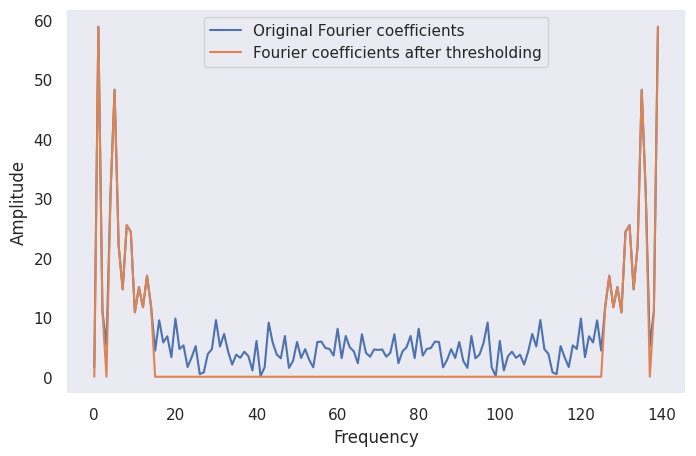

Output SNR :  10.528218278109478


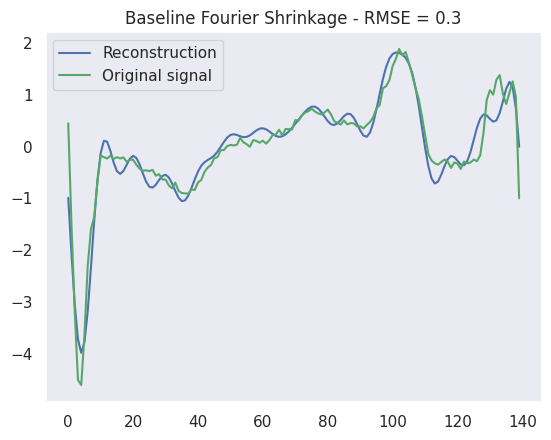

In [150]:
fourier = np.fft.fft(noisy_line)
threshold_percents = np.linspace(0.1, 0.99, 100)

best_prd = 5

for thresh in tqdm(threshold_percents):
    fourier_shrink = fourier * (np.abs(fourier) > thresh*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    rmse, snr, prd, d_max = metrics(line, denoised_line)
    if prd < best_prd:
        best_prd = prd
        best_thresh_fourier = thresh


fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
denoised_line = np.real(np.fft.ifft(fourier_shrink))
print("Best threshold : ", best_thresh_fourier)


plt.figure(figsize = (8, 5))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.plot(np.abs(fourier), label = "Original Fourier coefficients")
plt.plot(np.abs(fourier_shrink), label = "Fourier coefficients after thresholding")
plt.legend()

plt.show()

rmse, snr, prd, d_max = metrics(line, denoised_line)
print("Output SNR : ", snr)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Baseline Fourier Shrinkage - RMSE = " + str(round(rmse, 2)))
plt.legend()
plt.show()



Output SNR :  11.723355550036242


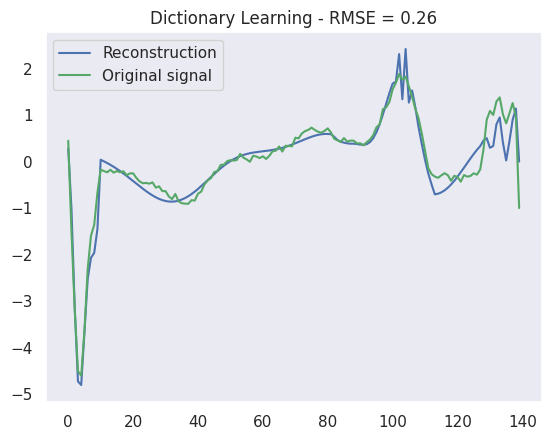

In [151]:
D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
rmse, snr, prd, d_max = metrics(line, denoised_line)
print("Output SNR : ", snr)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.legend()
plt.title("Dictionary Learning - RMSE = " + str(round(rmse, 2)))
plt.show()

# On another "test" signal ?

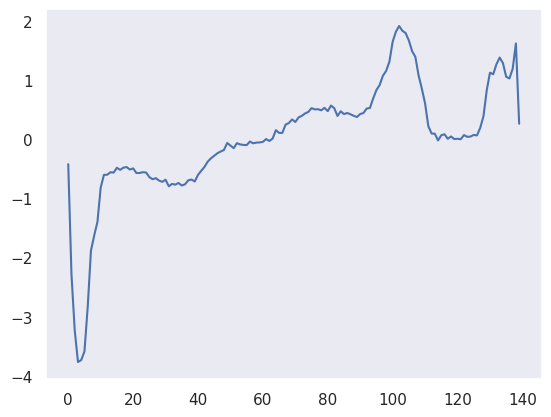

In [152]:
#Importation of signal 
# Load ARFF file
data, meta = arff.loadarff('ECG5000_TRAIN.arff')

# Convert to DataFrame
df = pd.DataFrame(data)
df = df[df['target'] == b'1'].copy() #keep only the first class
df.drop('target', axis=1, inplace=True) #drop the class number

i = 53
line = df.iloc[i]

line = line.astype(float).tolist()

#Normalize signal
line = line

plt.plot([i for i in range(len(line))],line)
plt.show()

Original RMSE :  0.3095530186671756
Original SNR :  10.168571860164723


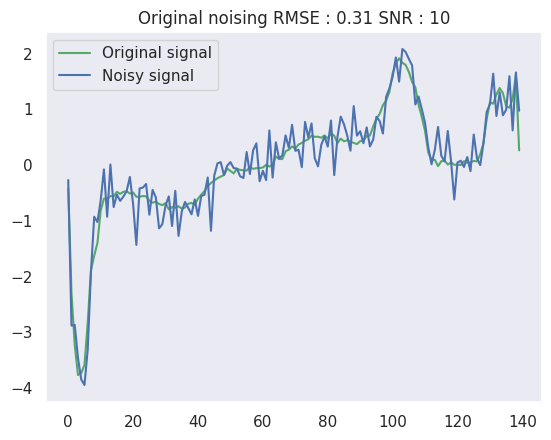

Input SNR :  10.168571860164723


In [153]:
noisy_line, noise_var , noise = addNoise(line, 10)
rmse, snr, prd, d_max = metrics(line, noisy_line)
print("Original RMSE : ", rmse)
print("Original SNR : ", snr)


plt.plot(line, 'g', label = "Original signal")
plt.plot(noisy_line, label = "Noisy signal")
plt.title("Original noising RMSE : " + str(round(rmse, 2)) + " SNR : " + str(10))
plt.legend()
plt.show()



print("Input SNR : ", snr)

Output SNR :  14.734074567286443


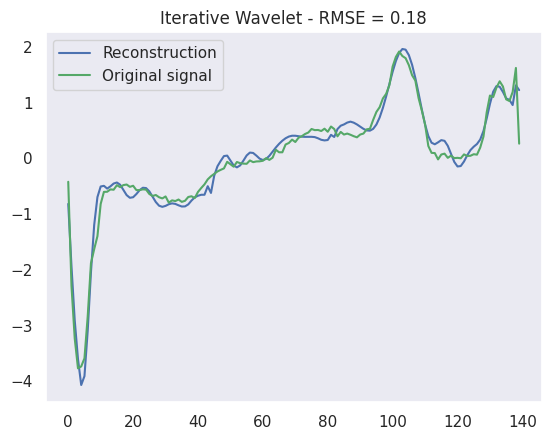

In [154]:
denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, 0.015)
mse, snr, prd, d_max = metrics(line, denoised_line)
print("Output SNR : ", snr)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Iterative Wavelet - RMSE = " + str(round(mse,2)))
plt.legend()
plt.show()

Output SNR :  13.479673444847444


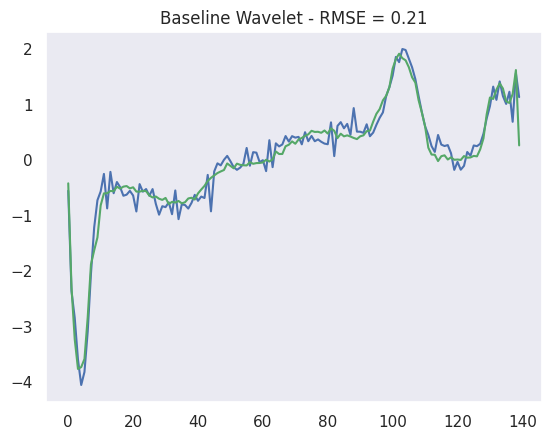

In [155]:
denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave)
mse, snr, prd, d_max = metrics(line, denoised_line)
print("Output SNR : ", snr)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Baseline Wavelet - RMSE = " + str(round(mse,2)))
plt.show()

Best threshold :  0.17191919191919192


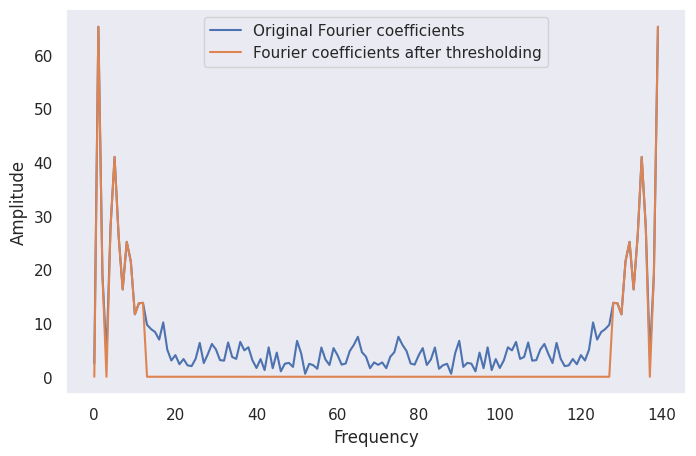

Output SNR :  12.294475462559951


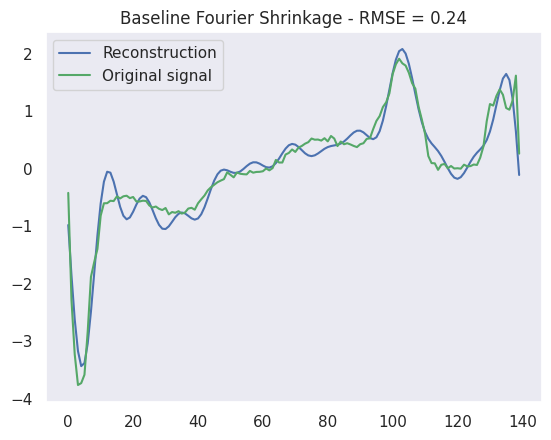

In [156]:
fourier = np.fft.fft(noisy_line)
fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
denoised_line = np.real(np.fft.ifft(fourier_shrink))
print("Best threshold : ", best_thresh_fourier)



plt.figure(figsize = (8, 5))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.plot(np.abs(fourier), label = "Original Fourier coefficients")
plt.plot(np.abs(fourier_shrink), label = "Fourier coefficients after thresholding")
plt.legend()

plt.show()

rmse, snr, prd, d_max = metrics(line, denoised_line)
print("Output SNR : ", snr)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Baseline Fourier Shrinkage - RMSE = " + str(round(rmse, 2)))
plt.legend()
plt.show()

Output SNR :  12.888060836245948


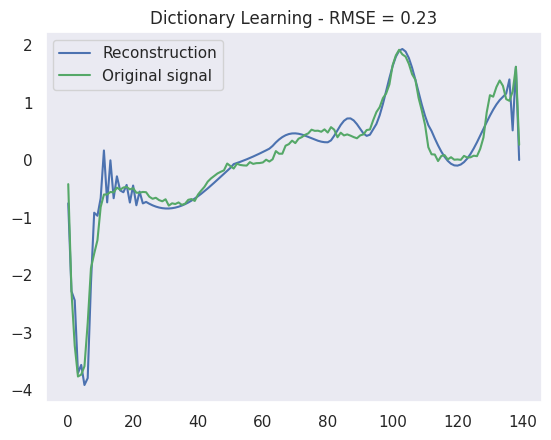

In [157]:
D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
rmse, snr, prd, d_max = metrics(line, denoised_line)
print("Output SNR : ", snr)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.legend()
plt.title("Dictionary Learning - RMSE = " + str(round(rmse, 2)))
plt.show()

# Varying noise - Algorithms comparison

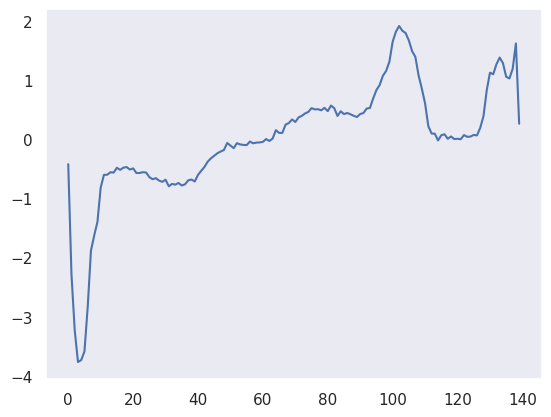

In [170]:
#Importation of signal 
# Load ARFF file
data, meta = arff.loadarff('ECG5000_TRAIN.arff')

# Convert to DataFrame
df = pd.DataFrame(data)
df = df[df['target'] == b'1'].copy() #keep only the first class
df.drop('target', axis=1, inplace=True) #drop the class number

i = 53
line = df.iloc[i]

line = line.astype(float).tolist()

#Normalize signal
line = line

plt.plot([i for i in range(len(line))],line)
plt.show()

In [171]:
list_SNR = [i for i in range(20)] #the list of SNR noises we want to try
precision = 3

#list of parameters we are going to test 
levels = [2,3,4]
alpha_1 = 0.015

threshold_percents = np.linspace(0.1, 1, 20)

threshold_percents_fourier = np.linspace(0.1, 0.99, 20)


#building the dataframe to store the results 
columns_name = ["SNR = " + str(list_SNR[i]) for i in range(len(list_SNR))]
lines_name = ["Iterative Wavelet", "Basic Wavelet", "Fourier Shrink", "Dictionnary Method"]
res_df = pd.DataFrame(index = lines_name, columns=columns_name)

for k in tqdm(range(len(list_SNR))):
    noisy_line, _, noise = addNoise(line, list_SNR[k])
        
    denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, alpha_1)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[0],columns_name[k]] = round(mse,precision)

    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave) 
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[1],columns_name[k]] = round(mse,precision)

    fourier = np.fft.fft(noisy_line)
    fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[2],columns_name[k]] = round(mse,precision)

    #dictionnary method
    D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
    support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[3],columns_name[k]] = round(mse,precision)

            

res_df

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


,SNR = 0,SNR = 1,SNR = 2,SNR = 3,SNR = 4,SNR = 5,SNR = 6,SNR = 7,SNR = 8,SNR = 9,SNR = 10,SNR = 11,SNR = 12,SNR = 13,SNR = 14,SNR = 15,SNR = 16,SNR = 17,SNR = 18,SNR = 19
Iterative Wavelet,0.571,0.473,0.405,0.403,0.301,0.338,0.271,0.27,0.246,0.205,0.199,0.211,0.174,0.145,0.141,0.133,0.136,0.13,0.096,0.1
Basic Wavelet,0.754,0.543,0.545,0.491,0.385,0.425,0.364,0.296,0.275,0.219,0.206,0.236,0.174,0.146,0.149,0.153,0.134,0.126,0.122,0.12
Fourier Shrink,1.078,0.693,0.624,0.489,0.429,0.449,0.372,0.279,0.274,0.292,0.286,0.303,0.285,0.223,0.25,0.238,0.269,0.262,0.26,0.24
Dictionnary Method,0.748,0.551,0.563,0.577,0.369,0.413,0.384,0.342,0.31,0.255,0.245,0.237,0.205,0.175,0.167,0.145,0.139,0.139,0.116,0.115


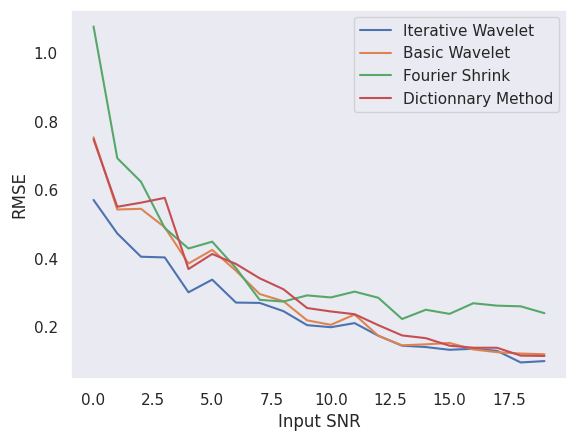

In [172]:
for i in range(len(lines_name)):
    plt.plot(list_SNR, res_df.iloc[i,:].values, label = lines_name[i])
plt.legend()
plt.xlabel("Input SNR")
plt.ylabel("RMSE")
plt.show()

In [173]:
list_SNR = [i for i in range(20)] #the list of SNR noises we want to try
precision = 3

#list of parameters we are going to test 
levels = [2,3,4]
alpha_1 = 0.015

threshold_percents = np.linspace(0.1, 1, 20)

threshold_percents_fourier = np.linspace(0.1, 0.99, 20)


#building the dataframe to store the results 
columns_name = ["SNR = " + str(list_SNR[i]) for i in range(len(list_SNR))]
lines_name = ["Iterative Wavelet", "Basic Wavelet", "Fourier Shrink", "Dictionnary Method"]
res_df = pd.DataFrame(index = lines_name, columns=columns_name)

for k in tqdm(range(len(list_SNR))):
    noisy_line, _, noise = addNoise(line, list_SNR[k])
        
    denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, alpha_1)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[0],columns_name[k]] = round(snr,precision)

    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave) 
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[1],columns_name[k]] = round(snr,precision)

    fourier = np.fft.fft(noisy_line)
    fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[2],columns_name[k]] = round(snr,precision)

    #dictionnary method
    D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
    support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[3],columns_name[k]] = round(snr,precision)

            

res_df

  5%|▌         | 1/20 [00:00<00:02,  6.35it/s]

100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


,SNR = 0,SNR = 1,SNR = 2,SNR = 3,SNR = 4,SNR = 5,SNR = 6,SNR = 7,SNR = 8,SNR = 9,SNR = 10,SNR = 11,SNR = 12,SNR = 13,SNR = 14,SNR = 15,SNR = 16,SNR = 17,SNR = 18,SNR = 19
Iterative Wavelet,5.195,6.901,5.715,8.522,9.199,9.926,9.738,10.567,11.768,13.789,13.619,14.372,16.478,15.114,16.224,18.257,18.57,18.442,20.117,19.473
Basic Wavelet,3.3,3.161,3.884,6.571,7.448,8.484,8.648,9.219,10.305,12.685,13.566,14.115,16.079,15.197,16.716,18.107,18.131,18.063,18.279,18.517
Fourier Shrink,1.052,1.181,1.637,4.947,7.636,8.924,8.095,9.664,8.608,12.328,10.712,11.454,11.564,12.476,12.361,12.34,11.674,12.419,11.631,11.675
Dictionnary Method,3.485,2.507,3.882,6.467,7.514,8.3,8.28,8.662,9.811,12.243,13.495,13.13,15.023,16.034,15.24,16.369,17.489,18.119,18.483,19.326


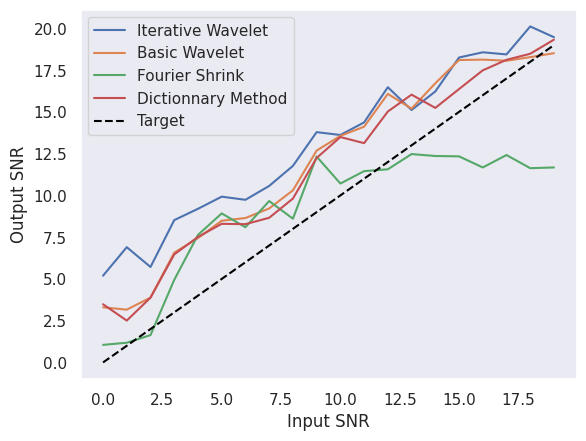

In [174]:
for i in range(len(lines_name)):
    plt.plot(list_SNR, res_df.iloc[i,:].values, label = lines_name[i])

plt.plot(list_SNR, list_SNR, label = "Target", linestyle = "--", color = "black")
plt.legend()
plt.xlabel("Input SNR")
plt.ylabel("Output SNR")
plt.show()

# Varying noise - Signal 7

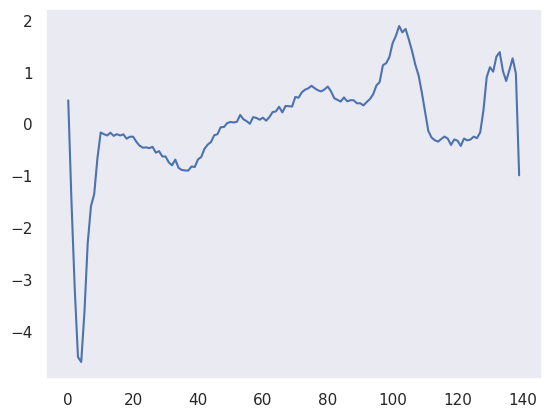

In [162]:
#Importation of signal 
# Load ARFF file
data, meta = arff.loadarff('ECG5000_TRAIN.arff')

# Convert to DataFrame
df = pd.DataFrame(data)
df = df[df['target'] == b'1'].copy() #keep only the first class
df.drop('target', axis=1, inplace=True) #drop the class number

i = 7
line = df.iloc[i]

line = line.astype(float).tolist()

#Normalize signal
line = line

plt.plot([i for i in range(len(line))],line)
plt.show()

In [163]:
list_SNR = [i for i in range(20)] #the list of SNR noises we want to try
precision = 3

#list of parameters we are going to test 
levels = [2,3,4]
alpha_1 = 0.015

threshold_percents = np.linspace(0.1, 1, 20)

threshold_percents_fourier = np.linspace(0.1, 0.99, 20)


#building the dataframe to store the results 
columns_name = ["SNR = " + str(list_SNR[i]) for i in range(len(list_SNR))]
lines_name = ["Iterative Wavelet", "Basic Wavelet", "Fourier Shrink", "Dictionnary Method"]
res_df = pd.DataFrame(index = lines_name, columns=columns_name)

for k in tqdm(range(len(list_SNR))):
    noisy_line, _, noise = addNoise(line, list_SNR[k])
        
    denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, alpha_1)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[0],columns_name[k]] = round(mse,precision)

    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave) 
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[1],columns_name[k]] = round(mse,precision)

    fourier = np.fft.fft(noisy_line)
    fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[2],columns_name[k]] = round(mse,precision)

    #dictionnary method
    D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
    support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[3],columns_name[k]] = round(mse,precision)

            

res_df

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


,SNR = 0,SNR = 1,SNR = 2,SNR = 3,SNR = 4,SNR = 5,SNR = 6,SNR = 7,SNR = 8,SNR = 9,SNR = 10,SNR = 11,SNR = 12,SNR = 13,SNR = 14,SNR = 15,SNR = 16,SNR = 17,SNR = 18,SNR = 19
Iterative Wavelet,0.63,0.528,0.568,0.385,0.379,0.405,0.333,0.215,0.249,0.248,0.218,0.207,0.194,0.171,0.162,0.144,0.131,0.161,0.126,0.134
Basic Wavelet,0.749,0.654,0.68,0.474,0.423,0.472,0.37,0.278,0.272,0.277,0.241,0.219,0.209,0.205,0.169,0.155,0.149,0.175,0.147,0.144
Fourier Shrink,1.036,0.903,0.724,0.581,0.49,0.493,0.43,0.351,0.341,0.323,0.278,0.313,0.318,0.298,0.239,0.285,0.245,0.278,0.302,0.221
Dictionnary Method,0.862,0.737,0.647,0.505,0.457,0.506,0.36,0.313,0.262,0.291,0.251,0.231,0.219,0.233,0.217,0.185,0.198,0.183,0.174,0.177


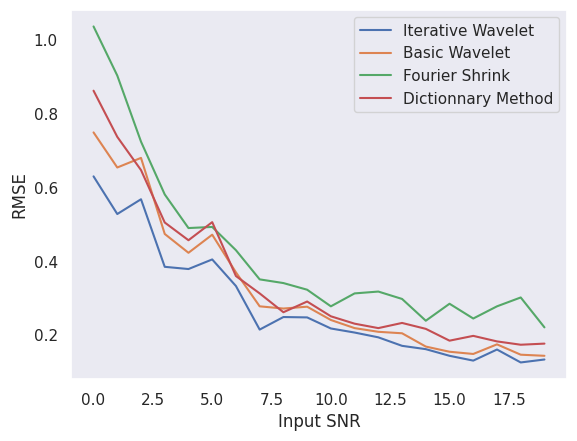

In [164]:
for i in range(len(lines_name)):
    plt.plot(list_SNR, res_df.iloc[i,:].values, label = lines_name[i])
plt.legend()
plt.xlabel("Input SNR")
plt.ylabel("RMSE")
plt.show()

In [165]:
list_SNR = [i for i in range(20)] #the list of SNR noises we want to try
precision = 3

#list of parameters we are going to test 
levels = [2,3,4]
alpha_1 = 0.015

threshold_percents = np.linspace(0.1, 1, 20)

threshold_percents_fourier = np.linspace(0.1, 0.99, 20)


#building the dataframe to store the results 
columns_name = ["SNR = " + str(list_SNR[i]) for i in range(len(list_SNR))]
lines_name = ["Iterative Wavelet", "Basic Wavelet", "Fourier Shrink", "Dictionnary Method"]
res_df = pd.DataFrame(index = lines_name, columns=columns_name)

for k in tqdm(range(len(list_SNR))):
    noisy_line, _, noise = addNoise(line, list_SNR[k])
        
    denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, alpha_1)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[0],columns_name[k]] = round(snr,precision)

    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave) 
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[1],columns_name[k]] = round(snr,precision)

    fourier = np.fft.fft(noisy_line)
    fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[2],columns_name[k]] = round(snr,precision)

    #dictionnary method
    D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
    support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[3],columns_name[k]] = round(snr,precision)

            

res_df

100%|██████████| 20/20 [00:01<00:00, 13.08it/s]


,SNR = 0,SNR = 1,SNR = 2,SNR = 3,SNR = 4,SNR = 5,SNR = 6,SNR = 7,SNR = 8,SNR = 9,SNR = 10,SNR = 11,SNR = 12,SNR = 13,SNR = 14,SNR = 15,SNR = 16,SNR = 17,SNR = 18,SNR = 19
Iterative Wavelet,5.513,6.797,7.218,6.811,8.465,9.133,9.981,10.926,11.314,12.255,12.455,12.701,14.643,15.196,16.257,16.356,15.609,18.247,17.003,18.519
Basic Wavelet,2.851,4.636,5.543,5.044,8.289,8.584,8.604,10.909,10.226,11.616,13.193,11.948,13.823,15.2,15.223,15.556,15.292,16.901,16.154,16.978
Fourier Shrink,0.7,1.273,4.74,3.804,6.078,6.454,7.799,8.678,8.961,10.798,10.042,10.31,10.392,10.651,10.616,12.221,10.47,11.381,11.225,10.352
Dictionnary Method,2.35,3.667,5.447,4.933,7.885,8.211,7.942,10.403,10.786,11.29,13.247,11.771,13.236,13.459,15.071,14.184,14.877,13.734,15.195,14.26


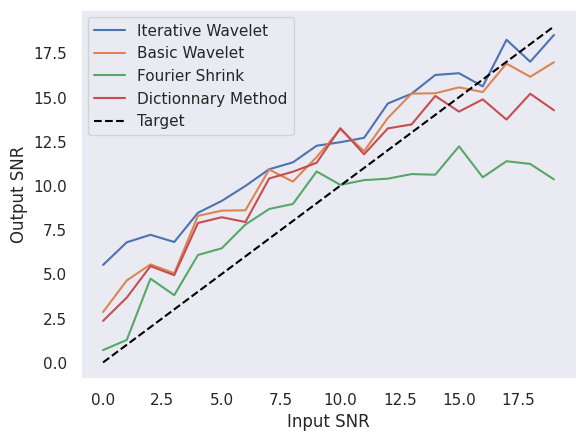

In [166]:
for i in range(len(lines_name)):
    plt.plot(list_SNR, res_df.iloc[i,:].values, label = lines_name[i])

plt.plot(list_SNR, list_SNR, label = "Target", linestyle = "--", color = "black")
plt.legend()
plt.xlabel("Input SNR")
plt.ylabel("Output SNR")
plt.show()